In [1]:
%load_ext autoreload
%autoreload 2
import warnings 
warnings.filterwarnings("ignore")

In [2]:
import os
import librosa
import ffmpeg
import pydub
import matplotlib.pyplot as plt
from music21 import converter
import math
import pretty_midi
# from deep_eurorack_control.models.ddsp.decoder import Decoder
# from torch.utils.data import DataLoader
# from deep_eurorack_control.datasets.ddsp import  NSynth_ddsp
# from deep_eurorack_control.helpers.ddsp import *
os.chdir(r"C:\Users\NILS\Documents\ATIAM\PAM\deep-eurorack-control\src")
from deep_eurorack_control.models.ddsp.ops import *



# ffmpeg_path = r"C:\Users\NILS\Documents\ATIAM\Informatique\PROJET\ffmpeg-2022-01-10-git-f37e66b393-essentials_build\bin"
# os.chdir(ffmpeg_path)

In [3]:
dataset_dir = r'C:\Users\NILS\Documents\ATIAM\PAM\Datasets\Dataset\02_Sonata_vn_vn'
file = "AuSep_1_vn_02_Sonata.wav"
file = os.path.join(dataset_dir,file)
midi_file = 'Sco_02_Sonata_vn_vn.mid'
midi_file = os.path.join(dataset_dir,midi_file)

In [4]:
sr=16000

In [5]:
audio,_ = librosa.load(file,sr)
pitch,pitch_conf = get_pitch(audio,sr=sr,frame_size=512)

In [ ]:
midi_data = pretty_midi.PrettyMIDI(midi_file)

In [39]:
note_file = r"Notes_1_vn_02_Sonata.csv"
note_file = os.path.join(dataset_dir,note_file)

In [43]:
notes = np.loadtxt(note_file)


In [49]:
for note in notes:
    start = get_closest_frame(note[0],times)
    end =  get_closest_frame(note[-1]+note[0],times)
    # vel = note.velocity/127
    freqs[start:end] = note[1]
    # vels[start:end] = vel

In [48]:
times = np.linspace(0,audio.shape[0]/sr,pitch.shape[0])
freqs = np.zeros_like(times)
vels = np.zeros_like(times)
def get_closest_frame(time,times):
    return(np.argmin(np.abs(times-time)))

In [214]:
instr = midi_data.instruments[0]
notes_list = instr.notes
for note in notes_list:
    start = get_closest_frame(note.start,times)
    end =  get_closest_frame(note.end,times)
    freq = librosa.midi_to_hz(note.pitch)
    vel = note.velocity/127
    
    freqs[start:end] = freq
    vels[start:end] = vel

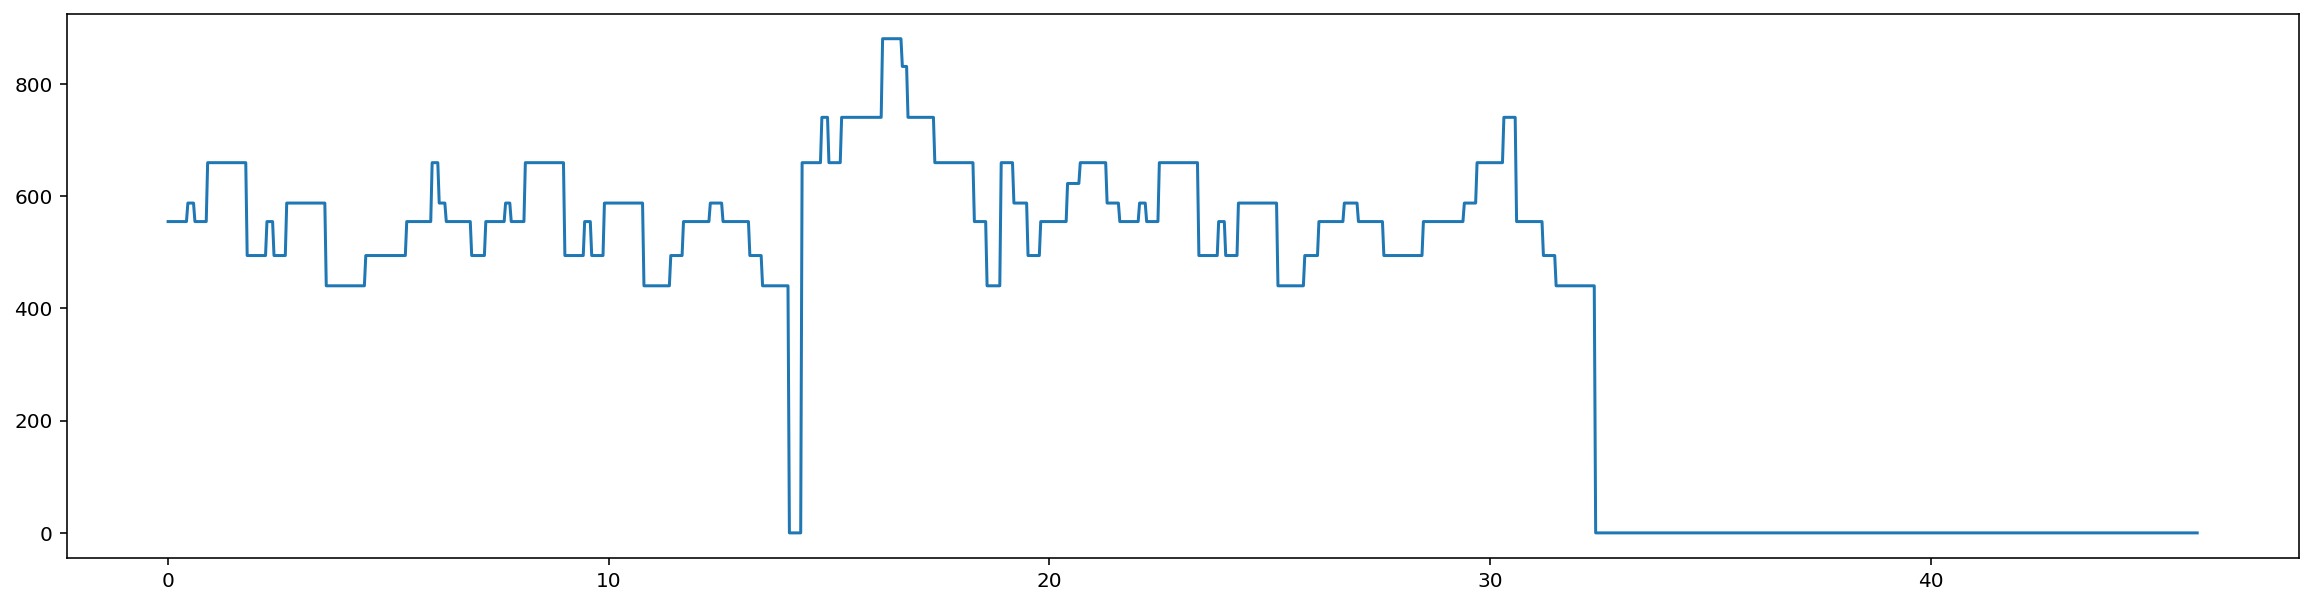

In [221]:
plt.figure(figsize=(20,5))
plt.plot((times),freqs)
# plt.plot(times,pitch)

In [188]:
# total_time = notes_list[-1].end-notes_list[0].start
# time_factor = (times[-1]-5)/total_time
time_factor=1.5

In [222]:
notes_list[-1]

Note(start=31.500000, end=32.400000, pitch=69, velocity=44)

In [156]:
notes_list

[Note(start=1.200000, end=1.505000, pitch=61, velocity=72),
 Note(start=1.500000, end=1.783750, pitch=64, velocity=76),
 Note(start=1.800000, end=2.400000, pitch=66, velocity=80),
 Note(start=2.400000, end=2.705000, pitch=66, velocity=78),
 Note(start=2.700000, end=2.983750, pitch=69, velocity=84),
 Note(start=3.000000, end=3.456875, pitch=68, velocity=78),
 Note(start=3.450000, end=3.590625, pitch=64, velocity=69),
 Note(start=3.600000, end=3.905000, pitch=69, velocity=85),
 Note(start=3.900000, end=4.183750, pitch=71, velocity=87),
 Note(start=4.200000, end=4.800000, pitch=69, velocity=72),
 Note(start=4.800000, end=5.400000, pitch=68, velocity=71),
 Note(start=5.400000, end=5.705000, pitch=66, velocity=70),
 Note(start=5.700000, end=5.983750, pitch=68, velocity=74),
 Note(start=6.000000, end=6.600000, pitch=66, velocity=72),
 Note(start=6.600000, end=7.200000, pitch=64, velocity=71),
 Note(start=7.200000, end=8.400000, pitch=61, velocity=67),
 Note(start=8.400000, end=8.705000, pitc

(7832,)


<Figure size 432x288 with 0 Axes>

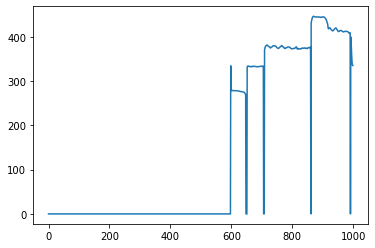

<Figure size 432x288 with 0 Axes>

In [84]:
print(pitch.shape)
start = 0
end = 1000
pitch_real = pitch*(pitch_conf>0.6)
plt.plot(pitch_real[start:end])
plt.figure()
# plt.plot(pitch_conf[:100])

In [57]:
audio_list=audio[start*256:end*256]


In [58]:
import IPython.display as ipd
ipd.Audio(audio_list,rate=sr)

In [87]:
def get_start_time(el,measure_offset,quantization):
    if (el.offset is not None) and (el.measureNumber in measure_offset):
        return int(math.ceil(((measure_offset[el.measureNumber] or 0) + el.offset)*quantization))
    # Else, no time defined for this element and the functino return None

def get_end_time(el,measure_offset,quantization):
    if (el.offset is not None) and (el.measureNumber in measure_offset):
        return int(math.ceil(((measure_offset[el.measureNumber] or 0) + el.offset + el.duration.quarterLength)*quantization))
    # Else, no time defined for this element and the functino return None
    
def get_pianoroll_part(part,quantization):
    # Get the measure offsets
    measure_offset = {None:0}
    for el in part.recurse(classFilter=('Measure')):
        measure_offset[el.measureNumber] = el.offset
    # Get the duration of the part
    duration_max = 0
    for el in part.recurse(classFilter=('Note','Rest')):
        t_end = get_end_time(el,measure_offset,quantization)
        if(t_end>duration_max):
            duration_max=t_end
    # Get the pitch and offset+duration
    piano_roll_part = np.zeros((128,math.ceil(duration_max)))
    for this_note in part.recurse(classFilter=('Note')):
        note_start = get_start_time(this_note,measure_offset,quantization)
        note_end = get_end_time(this_note,measure_offset,quantization)
        piano_roll_part[this_note.pitch.midi,note_start:note_end] = 1
    return piano_roll_part

# Here we provide a MIDI import function
def importMIDI(f):
    piece = converter.parse(f)
    all_parts = {}
    count = 0 
    for part in piece.parts:
        print(part)
        try:
            track_name = part[0].bestName()
        except AttributeError:
            count +=1
            track_name = 'None'+str(count)
        cur_part = get_pianoroll_part(part, 128);
        if (cur_part.shape[1] > 0):
            all_parts[track_name] = cur_part;
    print('Returning')
    return piece, all_parts
